# Baselines - Random

> *Versión preliminar*

Integrantes: 
  - Francisco Arenas
  - Sofía Rebolledo
  - Alvaro Romero

In [2]:
# FLAGS
FLAG_DATASET_DL = False

# CONSTANTS
RANDOM_SEED = 1  # None para random

## Instalación de librerías e importación de datos

In [3]:
# Actualizar pip
%pip install --upgrade pip
# Instalar versión específica de numpy
%pip install numpy~=1.26
# Dependencias para graficar y manipular datos
%pip install pandas matplotlib tqdm
# Dependencias para leer archivos Parquet
%pip install pyarrow fastparquet
# Para predicción
%pip install scikit-surprise scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Importar librerías
import os
import sys
import time
import surprise
import tracemalloc
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Crear directorios
PATH_DATASETS = "datasets"
PATH_DATASETS_FOODCOM = os.path.join(PATH_DATASETS, "foodcom")
PATH_DATASETS_MEALRECPLUS = os.path.join(PATH_DATASETS, "mealrecplus")
PATH_DATASETS_NUTRIGREEN = os.path.join(PATH_DATASETS, "nutrigreen")
os.makedirs(PATH_DATASETS, exist_ok=True)

/home/vscode/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
if FLAG_DATASET_DL:
  # Descargar "Recipes and Reviews" de Food.com
  os.system(f"curl -L -o {PATH_DATASETS_FOODCOM}.zip https://www.kaggle.com/api/v1/datasets/download/irkaal/foodcom-recipes-and-reviews")
  os.system(f"unzip -o {PATH_DATASETS_FOODCOM}.zip -d {PATH_DATASETS_FOODCOM}")
  # Eliminar el zip
  os.remove(f"{PATH_DATASETS_FOODCOM}.zip")

  # Cita: Dominio público (https://www.kaggle.com/datasets/irkaal/foodcom-recipes-and-reviews)

In [6]:
if FLAG_DATASET_DL:
  # Descargar "MealRecPlus" de WUT-IDEA
  os.system(f"curl -L -o {PATH_DATASETS_MEALRECPLUS}.zip https://github.com/WUT-IDEA/MealRecPlus/archive/refs/heads/main.zip")
  os.system(f"unzip -o {PATH_DATASETS_MEALRECPLUS}.zip -d {PATH_DATASETS_MEALRECPLUS}")
  # Eliminar el zip
  os.remove(f"{PATH_DATASETS_MEALRECPLUS}.zip")
  # Cita: Ming Li, Lin Li, Xiaohui Tao, and Jimmy Xiangji Huang. 2024. MealRec+: A Meal Recommendation Dataset with Meal-Course Affiliation for Personal- ization and Healthiness. In Proceedings of the 47th International ACM SIGIR Conference on Research and Development in Information Retrieval (SIGIR ’24), July 14–18, 2024, Washington, DC, USA. ACM, New York, NY, USA, 11 pages. https://doi.org/10.1145/3626772.3657857 (https://github.com/WUT-IDEA/MealRecPlus)

In [7]:
if FLAG_DATASET_DL:
  # Descargar "NutriGreen Image Dataset" de NutriGreen
  os.system(f"curl -L -o {PATH_DATASETS_NUTRIGREEN}.zip https://zenodo.org/api/records/10020545/files-archive")
  os.system(f"unzip -o {PATH_DATASETS_NUTRIGREEN}.zip -d {PATH_DATASETS_NUTRIGREEN}")
  # Eliminar el zip
  os.remove(f"{PATH_DATASETS_NUTRIGREEN}.zip")
  # Cita: https://data.niaid.nih.gov/resources?id=zenodo_8374046

## Random para predicción de ratings

In [8]:
# Función para dividir el dataset en train y test
def split_train_test(df: pd.DataFrame, test_size=0.2):
    """
    Prepara los datos para cargar en los modelos, de forma estratificada.
    """
    # Filtramos por recetas con más de una reseña
    total_recipes = df["RecipeId"].nunique()
    df_recipes = df.groupby("RecipeId").size()[df.groupby("RecipeId").size() > 1].index
    #print(f"Recetas con más de una reseña: {len(df_recipes)}/{total_recipes}")
    # Dividimos el dataframe en dos partes: recetas con múltiples reseñas y otras
    df_recipes_split = df[df["RecipeId"].isin(df_recipes)]
    df_recipes_antisplit = df[~df["RecipeId"].isin(df_recipes)]
    # Dividimos el dataframe con múltiples reseñas en train y test
    df_train, df_test = train_test_split(
        df_recipes_split, 
        test_size=test_size, 
        random_state=RANDOM_SEED, 
        stratify=df_recipes_split["RecipeId"]
    )
    # Concatenamos el train con las recetas con una sola reseña
    df_train = pd.concat([df_train, df_recipes_antisplit], ignore_index=True)
    # Convertimos los datos a un formato que Surprise puede manejar
    reader = surprise.Reader(rating_scale=(0, 5))
    sp_train = surprise.Dataset.load_from_df(df_train[['AuthorId', 'RecipeId', 'Rating']], reader=reader)
    sp_test = surprise.Dataset.load_from_df(df_test[['AuthorId', 'RecipeId', 'Rating']], reader=reader)
    # Preparamos trainset y testset
    trainset = sp_train.build_full_trainset()
    testset = sp_test.build_full_trainset().build_testset()

    return trainset, testset

# Definimos un decorador para medir memoria, tiempo y otros
def profiler(rating: bool = False, ranking: bool = False):
    def decorator(func):
        def wrapper(*args, **kwargs) -> tuple:
            # Definimos parámetros de seguimiento
            params = {
                "time": time.time(),
                "memory": 0,  # En MB
                "rmse": None,
                "precision@k": None,
                "recall@k": None,
                "map@k": None,
                "ndcg@k": None,
                "diversity": None,
                "novelty": None,
            }
            # Iniciamos el seguimiento de parámetros
            tracemalloc.start()
            # Ejecutamos la función
            result = func(*args, **kwargs)
            # Obtenemos los resultados
            params["time"] = time.time() - params["time"]
            params["memory"] = tracemalloc.get_traced_memory()[1] / 10**6
            tracemalloc.stop()
            # Si es un modelo de rating
            if rating:
                params["rmse"] = surprise.accuracy.rmse(result, verbose=False)
            # Si es un modelo de ranking
            if ranking:
                threshold = 5
                k = 10
                #params["recall@10"] = metric_recall_at_k(result, k=k, threshold=threshold)
                #params["map@10"] = metric_map_at_k(result, k=k, threshold=threshold)
                #params["ndcg@10"] = metric_ndcg_at_k(result, k=k, threshold=threshold)
                #params["diversity"] = metric_diversity_at_k(result, k=k)
                #params["novelty"] = metric_novelty_at_k(result, k=k)

            # Devolvemos los resultados
            return result, params
        return wrapper
    return decorator

# Función para graficar
def plot_parameter(results: list, param_name: str, metric_name: str, plot_title: str, model_name: str):
    x, y = zip(*results)
    plt.plot(x, y, 'ro-', label=metric_name)
    plt.legend()
    plt.title(plot_title)
    plt.xlabel(param_name)
    plt.ylabel(metric_name)
    os.makedirs("output", exist_ok=True)
    plt.savefig(os.path.join("output", f"{model_name}_{metric_name}.png"), dpi=300, bbox_inches='tight')
    plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [04:27<00:00, 26.79s/it]


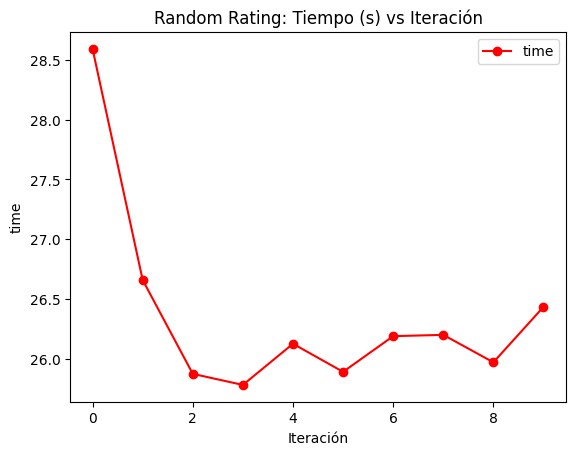

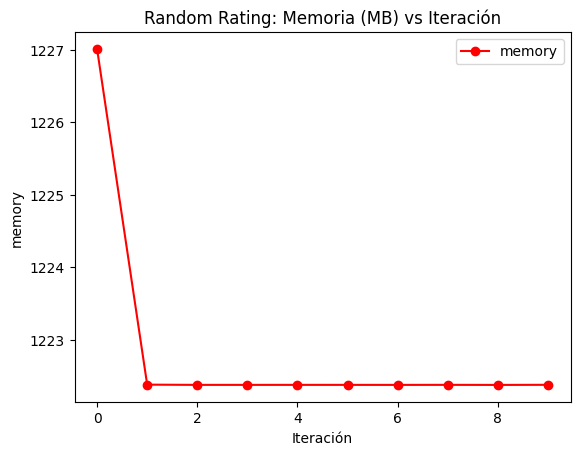

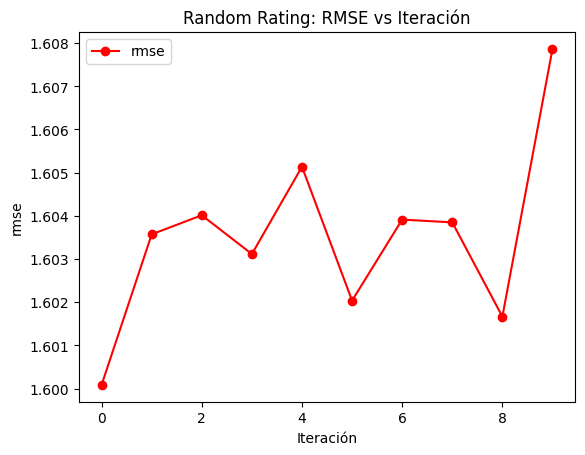

In [10]:
# RandomPredictor
@profiler(rating=True)
def run_random_rating(**kwargs):
    """
    Función para ejecutar el algoritmo de predicción aleatoria NormalPredictor de Surprise. Devuelve las predicciones.
    """
    # Cargamos los datos
    df = pd.read_parquet(os.path.join(PATH_DATASETS_FOODCOM, "reviews.parquet"))
    # Cargamos los datos de entrenamiento y validación
    trainset, testset = split_train_test(df)
    # Definicion de algoritmo
    algorithm = surprise.NormalPredictor(**kwargs)
    # Entrenamiento y predicción del modelo
    algorithm.fit(trainset)
    predictions = algorithm.test(testset)
    # Retorna las predicciones
    return predictions

# Random Ranking para 10 iteraciones
i_values = range(10)
results_time = []
results_memory = []
results_rmse = []
for i in tqdm(i_values):
    predictions, params = run_random_rating()
    results_time.append((i, params["time"]))
    results_memory.append((i, params["memory"]))
    results_rmse.append((i, params["rmse"]))
# Graficamos los resultados
model_name = "random_rating"
param_name = "Iteración"
title_model = "Random Rating"
plot_parameter(results_time, param_name=param_name, metric_name="time", plot_title=f"{title_model}: Tiempo (s) vs {param_name}", model_name=model_name)
plot_parameter(results_memory, param_name=param_name, metric_name="memory", plot_title=f"{title_model}: Memoria (MB) vs {param_name}", model_name=model_name)
plot_parameter(results_rmse, param_name=param_name, metric_name="rmse", plot_title=f"{title_model}: RMSE vs {param_name}", model_name=model_name)